# Import Libraries

In [22]:
import numpy             as np
import pandas            as pd
import seaborn           as sb
import plotly.express    as px
import matplotlib.pyplot as plt
import math
import random
import sklearn.metrics

from sklearn                 import metrics
from numpy.linalg            import norm
from sklearn                 import preprocessing
from numpy.linalg            import eig
from numpy.linalg            import inv
from tqdm                    import tqdm
from scikitplot.metrics      import plot_confusion_matrix

# Function

## - General Function

In [2]:
#Return Label converted from String to Int
def convert_Label(y):
    labelEncoder = preprocessing.LabelEncoder()#Initialize LabelEncoder Object

    labelEncoder.fit(y)
    y_n =labelEncoder.transform(y)

    return y_n

#Return standardized data
def standard(x):
    return(x-x.mean())/x.std()

#Return float number for the accuracy
def get_accuracy(y_actual, y_predicted):
    
    #Build confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y_actual, y_predicted)
    plot_confusion_matrix(y_actual, y_predicted)
    plt.show()

    accuracy = 0
    #Calculate accuracy with diagonal of confusion matrix
    for i in range(len(confusion_matrix)):
        accuracy += confusion_matrix[i][i]

    accuracy = (accuracy/len(y_actual))
    print(accuracy)
    print(metrics.classification_report(y_actual, y_predicted, digits=6))

    return accuracy

## - Function for PCA

In [3]:
def eigen_calc(A):
    #find eigenvalue & eigenvectors
    eigenValues, eigenVectors = eig(A)
    #sort eigenvector 
    i =  np.argsort(eigenValues)[::-1]
    sorted_eigenvalue   =  eigenValues[i]
    sorted_eigenvectors =  eigenVectors[:,i]

    return sorted_eigenvalue, sorted_eigenvectors

def pca(dataset, testset, n_comp):
    
    #1 Calculate covariance matrix
    cov_mat = np.cov(dataset, rowvar = False )
    print("Forma della matrice di covarianza", cov_mat.shape)
    #2 Find eigenvalue & eigenvectors
    eig_val, eig_vec = eigen_calc(cov_mat)
    eig_vec = eig_vec/norm(eig_vec)
    #3 Choose number of component 
    expl_var = np.cumsum(eig_val)/np.sum(eig_val)
    plt.plot(expl_var)
    #4 Select 'n_comp' principal component 
    eig_vec_sub = eig_vec[:, 0:n_comp]
    #5 Project eigenvector on dataset
    pca_data = pd.DataFrame(dataset.dot(eig_vec_sub))     
    pca_test = pd.DataFrame(np.dot(eig_vec_sub.T, testset.T).T)


    return pca_data, pca_test

## - Function for LDA

In [4]:
#Return dict with class as Key
def div_class(X, Y):
    
    mat_class = {}

    #initialize dict with class as key
    for k in np.unique(Y):
        mat_class[k] = []
        
    #insert data in dict for each class
    for i in X.index:
        mat_class[X.loc[i,'Activity']].append(X.iloc[i,:-1])

    return mat_class
    
#Return Array with mean for each class
def mean_class(X):
        
    mean = []

    for k in X:
        mean.append(np.mean(X[k], axis=0))

    return mean

#Return the within scatter matrix
def w_scatter_matrix(X, Y):
    
    cov = {}
    #initialize dict with class as key
    for k in np.unique(Y):
        cov[k] = []

    #insert cov_matrix in dict for each class
    for key in X:
        cov[key].append(np.cov(pd.DataFrame(X[key]), rowvar=False))
        
    #calculate within scatter matrix
    within_scatter_matrix = np.zeros((len(X[0][0]), len(X[0][0])))

    for i in range(len(within_scatter_matrix)):
        for j in range(len(within_scatter_matrix)):
            for c in X:
                within_scatter_matrix[i][j] += cov[c][0][i][j]

    return within_scatter_matrix

#Return the between scatter matrix
def b_scatter_matrix(X, M):
    
    between_scatter_matrix = 0

    #Array of number of samples for each class
    N = []
    for key in X:
        N.append(len(X[key]))

    #Array of number of samples  for mean for each class
    n_mu = []
    for key in X:
        n_mu.append(N[key]*M[key])

    n_sum = sum(N)

    x_mean = (1/n_sum) * (sum(n_mu))

    for k in X:
        between_scatter_matrix += np.dot(N[k]*(M[k] - x_mean), (M[k] - x_mean).T)

    return between_scatter_matrix

#Return Train & Test set after LDA
def lda(train, test, train_lb, n_comp):  

    #Divide Dataset for each class
    class_data = div_class(train, train_lb)

    #Calculate Within  Scatter Matrix
    w_scatter  = w_scatter_matrix(class_data, train_lb)

    #Calculate Between Scatter Matrix

        #Calculate mean for each class
    class_mean = mean_class(class_data)

    b_scatter = b_scatter_matrix(class_data, class_mean)

    #Find final form
    w_scatter_inverted = pd.DataFrame(inv(w_scatter))
    lambda_w = np.dot(w_scatter_inverted, b_scatter)
    
    #Calculate eigenvectors that maximize J(W) 
    eigenVal, eigenVec = eigen_calc(lambda_w)

    #Choose eigenvectors
    eig_vec_sub = eigenVec[:,0:n_comp]

    #Project eigenvectors on dataset
    train = train.loc[:, train.columns != 'Activity']
    x_train_lda = train.dot(eig_vec_sub)
    x_test_lda  = pd.DataFrame(np.dot(eig_vec_sub.T, test.T).T)

    return x_train_lda, x_test_lda

## - Function for KNN

In [5]:
#return euclidean distance between two point p1 & p2
def get_dist_euclidea(p1, p2):
    distance = 0
    for i in range(len(p1)):
        distance += ((p2[i] - p1[i])**2)
    
    return math.sqrt(distance)

#return matrix with 3 columns: - point, - distance, - label
def get_neighbor(p_query, X):

    columns = ['point']
    neighbor = pd.DataFrame(X.index.to_numpy(), columns= columns )
    neighbor['distance'] = 0
    neighbor['label']    = 0

    #calculate distance between query point and each other point
    for i in neighbor.index:
            neighbor.loc[i,'distance'] = get_dist_euclidea(p_query, X.iloc[i, :])
            neighbor.loc[i,'label']    = X.loc[i,'Activity']

    return neighbor

#returns the nearest k neighbors from the point that we are classifying
def get_neirest_neighbor(neighbor, k):

    nearest_neighbor = neighbor.sort_values(by="distance", ascending=1)
    nearest_neighbor = nearest_neighbor.iloc[:k]

    return nearest_neighbor

#return the prediction class for the point that we are classifying
def get_prediction(nearest_neighbor):

    frequency = 0
    var   = 0

    #Assign the most frequent label
    for c in nearest_neighbor.label.unique():        
        x = nearest_neighbor[nearest_neighbor['label'] == c]
       
        if len(x) > frequency:
            frequency = len(x)
            var   = x.iloc[0,2]
            
    return var

#Return predicted label for single point 'query_point'
def knn(query_point, X, k):

   X.index = range(0, len(X))

   #calculate distance between the query point and the training set
   neighbor = get_neighbor(query_point, X)

   #obtain the k nearest neighbor
   nearest_neighbor_class = get_neirest_neighbor(neighbor, k)

   #predict the class of query point
   prediction = get_prediction(nearest_neighbor_class)

   return prediction

# Pipeline

## 1. Data Collection 

In [6]:
#Import Train & Test set
train = pd.read_csv('../Data/train.csv')
test  = pd.read_csv('../Data/test.csv')

### 1.2 Data Comprehension

In [7]:
#Shape of Dataset
print("Shape of Train set", train.shape)
print("Shape of Test  set", test.shape)

Shape of Train set (7352, 563)
Shape of Test  set (2947, 563)


In [8]:
#Preview of train set
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [9]:
#View each Activity in Dataset
print("Different Activity in Dataset:")
train.Activity.unique()

Different Activity in Dataset:


array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [10]:
#Frequency of each Activity
print("Frequency of each Activity")
train['Activity'].groupby(train['Activity']).count()

Frequency of each Activity


Activity
LAYING                1407
SITTING               1286
STANDING              1374
WALKING               1226
WALKING_DOWNSTAIRS     986
WALKING_UPSTAIRS      1073
Name: Activity, dtype: int64

In [11]:
#Count Activity for each subject
px.histogram(data_frame=train, x="subject", color="Activity",barmode='group')

In [12]:
#View the parameters of Dataset
print("Parameters before Standardization:")
pd.DataFrame(train).describe()

Parameters before Standardization:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


### 1.3 Splitting & Standardization of Dataset

In [13]:
#Extract Label from Train & Test Set

#Train & Test set without Label
x_train = train.loc[:, train.columns != 'Activity']#Train Set
x_train = x_train.loc[:, x_train.columns != 'subject']#Train Set

x_test  = test.loc[:, test.columns != 'Activity']#Test  set
x_test = x_test.loc[:, x_test.columns != 'subject']#Test Set


#String Label for Train & Test set
y_train = train.Activity#Train Label
y_test  = test.Activity #Test  Label

#Int Label for Train & Test set
y_train_n = convert_Label(y_train)
y_test_n  = convert_Label(y_test)

In [14]:
x_train = standard(x_train)#Train Set Standardization
x_test  = standard(x_test)#Test Set Standardization
x_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,...,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03
mean,8.381882e-15,1.360597e-16,-5.324570e-15,-1.979555e-15,-2.678262e-15,-3.624866e-15,-4.231276e-15,2.603829e-15,2.975676e-15,3.792759e-16,...,-1.503754e-15,1.120979e-15,-7.024781e-15,4.871572e-17,-4.654873e-18,-2.598310e-17,4.777946e-17,-2.125582e-15,3.493004e-16,8.287410e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.813925e+01,-2.406988e+01,-1.572978e+01,-8.792764e-01,-9.727257e-01,-9.440145e-01,-8.712843e-01,-9.735585e-01,-9.510475e-01,-9.758504e-01,...,-4.483353e+00,-2.144314e+00,-1.217458e+00,-2.925484e+00,-2.235494e+00,-1.658262e+00,-2.079646e+00,-9.973544e-01,-3.558535e+00,-3.380187e+00
25%,-1.638582e-01,-1.756307e-01,-2.092656e-01,-8.631281e-01,-9.294663e-01,-8.968028e-01,-8.561706e-01,-9.286192e-01,-9.033588e-01,-8.587230e-01,...,-5.935840e-01,-7.339086e-01,-7.161599e-01,-3.866278e-01,-6.507494e-01,-8.071617e-01,-7.748532e-01,-6.301555e-01,-2.570847e-01,-3.113314e-01
50%,3.850240e-02,1.167061e-02,8.206385e-03,-7.593756e-01,-6.783303e-01,-6.081180e-01,-7.550522e-01,-6.799602e-01,-6.060835e-01,-7.584903e-01,...,3.468748e-02,-1.142519e-01,-2.808939e-01,2.450848e-03,1.507215e-02,1.477437e-05,1.174332e-02,-4.295960e-01,4.150803e-01,2.138701e-01
75%,1.988718e-01,1.693790e-01,2.003602e-01,8.081076e-01,9.483971e-01,8.176492e-01,7.966371e-01,9.470407e-01,8.221719e-01,8.290848e-01,...,6.526152e-01,5.608230e-01,3.947416e-01,4.221715e-01,6.483850e-01,8.177859e-01,7.643676e-01,-3.816311e-02,6.378898e-01,5.881780e-01
max,1.032591e+01,2.493708e+01,1.958396e+01,3.577703e+00,2.839333e+00,3.832827e+00,3.844889e+00,3.075619e+00,3.878450e+00,2.696930e+00,...,3.272618e+00,4.038951e+00,5.143761e+00,2.943456e+00,2.225741e+00,1.627440e+00,2.096467e+00,2.910370e+00,1.410395e+00,3.785133e+00


## 2. Feature Exctraction

### - 2.1. PCA - Principal Component Analysis

Forma della matrice di covarianza (561, 561)


c:\Users\USER\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



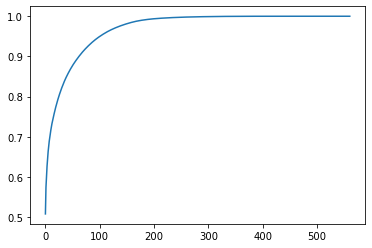

In [15]:
#Apply PCA
n_components = 100
x_train, x_test = pca(x_train.to_numpy(), x_test.to_numpy(), n_components)

Shape of Train set before PCA (7352, 563)
Shape of Train set after  PCA (7352, 100)


c:\Users\USER\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning:

Casting complex values to real discards the imaginary part



<AxesSubplot:xlabel='0', ylabel='1'>

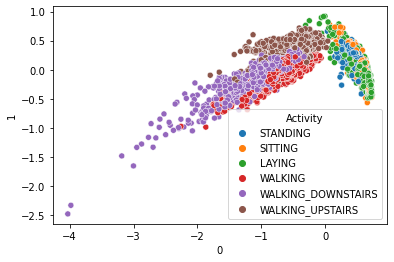

In [16]:
#Plot data after PCA
print("Shape of Train set before PCA", train.shape)
print("Shape of Train set after  PCA", x_train.shape)
sb.scatterplot(data = x_train, x=0, y=1, hue=y_train)

### - 2.2 FLDA - Fisher's Linear Discriminant Analysis

In [17]:
#Add label at Dataset
x_train['Activity'] = y_train_n

#Apply LDA
n_comp = 5
x_train, x_test = lda(x_train, x_test, y_train_n, n_comp)

C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2770155514.py:44: ComplexWarning:

Casting complex values to real discards the imaginary part



c:\Users\USER\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning:

Casting complex values to real discards the imaginary part



<AxesSubplot:xlabel='0', ylabel='1'>

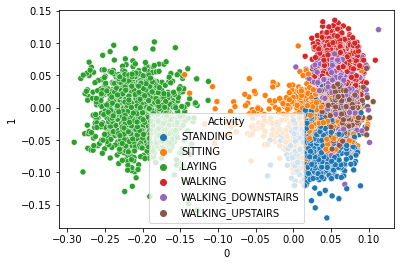

In [18]:
#Plot data after LDA
sb.scatterplot(data=x_train, x=0, y=1, hue=y_train)

## 3. Classification

### - KNN (K Neirest Neighbor)

#### Training for find best k

In [19]:
#Add label to dataset
x_train["Activity"] = y_train_n

In [20]:
train_pred = []

for idx in tqdm(x_train.index):
    query_p = x_train.loc[idx, x_train.columns != 'Activity']
    pred = knn(query_p, x_train.loc[x_train.index != idx, :], 24)
    train_pred.append(pred)

"""
#Code for Leave One Out validation
accuracy = {}

max_score = 0
k_best    = 0

for k in range(5, 10):

    train_pred = []
    accuracy[k] = []

    for idx in tqdm(x_train.index):
        query_p = x_train.loc[idx, x_train.columns != 'Activity']
        pred = knn(query_p, x_train.loc[x_train.index != idx, :], k)
        train_pred.append(pred)

    score = get_accuracy(y_train_n, train_pred)
    accuracy[k].append(score)

    if score > max_score:
        max_score = score
        k_best    = k
"""
#just some accuracy result        
#k=5:  0.7774755168661589
#k=6:  0.7808759521218716
#k=7:  0.786588683351469
#k=9:  0.7914853101196954
#k=24: 0.7995103373231773


  0%|          | 0/7352 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 1/7352 [00:01<3:17:44,  1.61s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 2/7352 [00:03<3:17:25,  1.61s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 3/7352 [00:04<3:16:18,  1.60s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 4/7352 [00:06<3:15:10,  1.59s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 5/7352 [00:07<3:14:14,  1.59s/it]

"\n#Code for Leave One Out validation\naccuracy = {}\n\nmax_score = 0\nk_best    = 0\n\nfor k in range(5, 10):\n\n    train_pred = []\n    accuracy[k] = []\n\n    for idx in tqdm(x_train.index):\n        query_p = x_train.loc[idx, x_train.columns != 'Activity']\n        pred = knn(query_p, x_train.loc[x_train.index != idx, :], k)\n        train_pred.append(pred)\n\n    score = get_accuracy(y_train_n, train_pred)\n    accuracy[k].append(score)\n\n    if score > max_score:\n        max_score = score\n        k_best    = k\n"

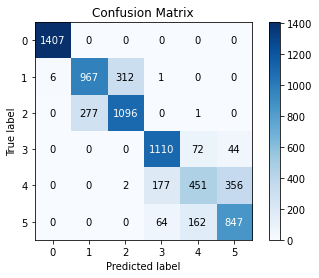

0.7995103373231773
              precision    recall  f1-score   support

           0   0.995754  1.000000  0.997872      1407
           1   0.777331  0.751944  0.764427      1286
           2   0.777305  0.797671  0.787356      1374
           3   0.821006  0.905383  0.861133      1226
           4   0.657434  0.457404  0.539474       986
           5   0.679230  0.789376  0.730172      1073

    accuracy                       0.799510      7352
   macro avg   0.784677  0.783630  0.780072      7352
weighted avg   0.796013  0.799510  0.794346      7352



0.7995103373231773

In [23]:
get_accuracy(y_train_n, train_pred)

## Testing

In [24]:
#Testing with k best for the training set
prediction = []
for idx in tqdm(x_test.index): 
        query_point = x_test.iloc[idx,:]
        y_predict = knn(query_point, x_train, 24)
        prediction.append(y_predict)

  0%|          | 0/2947 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 1/2947 [00:01<1:01:49,  1.26s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 2/2947 [00:02<1:02:22,  1.27s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 3/2947 [00:03<1:02:22,  1.27s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 4/2947 [00:05<1:02:26,  1.27s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_3088\2215106732.py:7: ComplexWarning:

Casting complex values to real discards the imaginary part

  0%|          | 5/2947 [00:06<1:02:20,  1.27s/it]

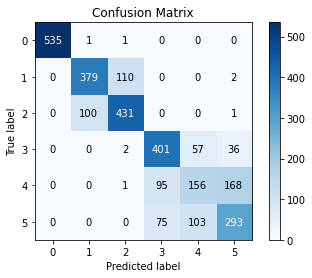

0.7448252460128945
              precision    recall  f1-score   support

           0   1.000000  0.996276  0.998134       537
           1   0.789583  0.771894  0.780639       491
           2   0.790826  0.810150  0.800371       532
           3   0.702277  0.808468  0.751640       496
           4   0.493671  0.371429  0.423913       420
           5   0.586000  0.622081  0.603502       471

    accuracy                       0.744825      2947
   macro avg   0.727059  0.730050  0.726366      2947
weighted avg   0.738745  0.744825  0.739802      2947



0.7448252460128945

In [25]:
get_accuracy(y_test_n, prediction)